In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [31]:
path = os.path.abspath('..') + '/' + "datasets/model_dataset.csv"
df = pd.read_csv(path)

attack_cols = ['label_spoofing', 'label_mitm', 'label_ddos', 'label_gps_spoofing', 'label_malware', 'label_jamming', 'label_protocol_exploit']
df = df.drop(['timestamp', 'drone_gps_coordinates', 'label_normal'], axis=1)
df['anomaly'] = df[attack_cols].max(axis=1)
df = df.drop(columns=attack_cols)
df = df.drop(columns=["anomaly"]) # drop labels because k-means is unsupervised

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[['communication_protocol', 'encryption_type']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['communication_protocol', 'encryption_type']))
df = pd.concat([df.drop(['communication_protocol', 'encryption_type'], axis=1), encoded_df], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_pca)

distances = np.linalg.norm(X_pca - kmeans.cluster_centers_[kmeans.labels_], axis=1)

threshold = np.percentile(distances, 95)

df['distance'] = distances

df['anomaly'] = (df['distance'] > threshold).astype(int)

print(df['anomaly'].value_counts())


anomaly
0    21511
1     1133
Name: count, dtype: int64


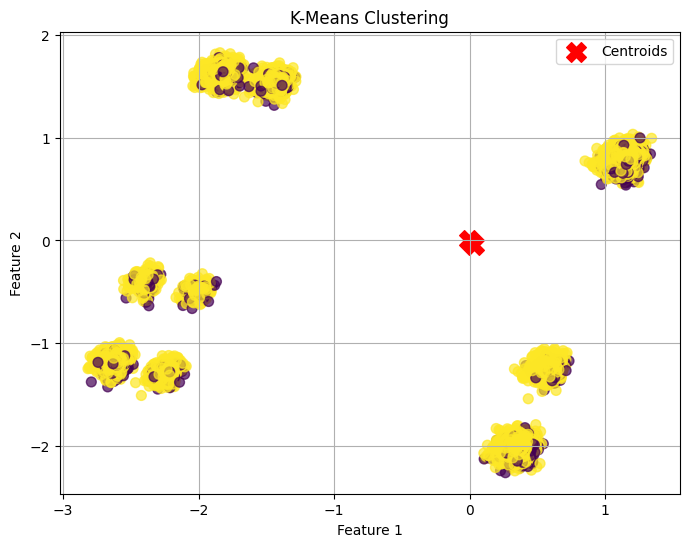

In [33]:
labels = kmeans.predict(X_pca)
centroids = kmeans.cluster_centers_
plt.figure(figsize=(8, 6))

# Plot data points colored by cluster
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='viridis', alpha=0.7)

# Plot cluster centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

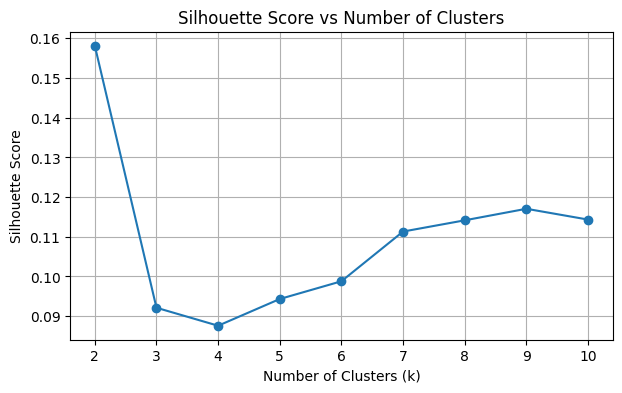

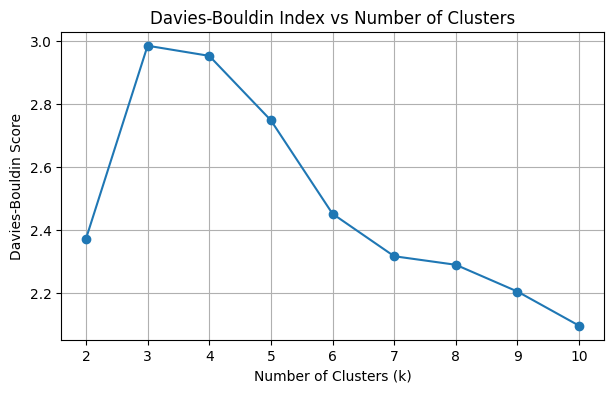

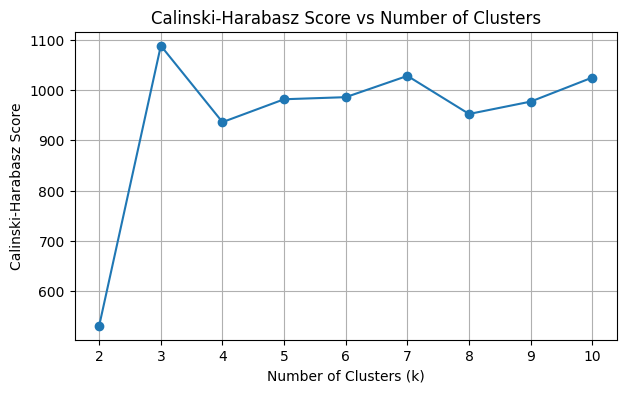

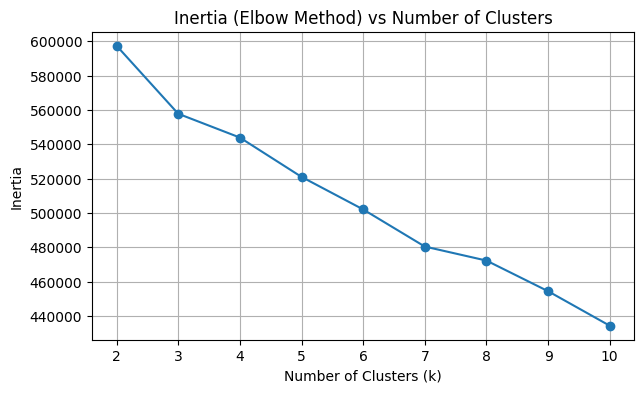

In [ ]:
k_values = range(2, 11)

silhouette_scores = []
db_scores = []
ch_scores = []
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)

    silhouette_scores.append(silhouette_score(X_pca, labels))
    db_scores.append(davies_bouldin_score(X_pca, labels))
    ch_scores.append(calinski_harabasz_score(X_pca, labels))
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(7,4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(k_values, db_scores, marker='o')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(k_values, ch_scores, marker='o')
plt.title('Calinski-Harabasz Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(k_values, inertias, marker='o')
plt.title('Inertia (Elbow Method) vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()
